In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import xarray
import sys
import json, zlib
import qtensor.tools
sys.path.append('../data/generators')
import miplog_helper
from functools import partial

In [3]:
def to_mh(item) -> miplog_helper.MiplogData:
    starts, *diffs = item
    return miplog_helper.MiplogData.from_start_and_diffs(starts, diffs)

def get_colors(n, cm=plt.cm.gnuplot2, offset=0.25):
    return [cm(offset + x*(1-2*offset)) for x in np.linspace(0, 1, n)]

def approx_ratio(p):
    ps = [qtensor.tools.BETHE_QAOA_VALUES[str(p)]['val'] for p in range(1, 12)]
    AR = ps[p-1]
    if AR>0:
        return AR
    else:
        raise KeyError
        
def load_json_zlib(file):
    with open(file, 'rb') as f:
        data = f.read()
    jss = zlib.decompress(data)
    dic = json.loads(jss)
    return xarray.DataArray.from_dict(dic)

In [4]:
mqlib = xarray.load_dataarray('../data/mqlib_cost_v_N.nc')
gurobi = load_json_zlib('../data/gurobi_match_d3_gpsymLin2.json.zlib')
mqlib_results = load_json_zlib('../data/mqlib_results_v_N.json.zlib')
#qvar_data = xarray.open_dataarray('../data/qaoa_variance_nsamples1000.nc')
qvar_coef = 0.128

/home/plate/.local/lib/python3.10/site-packages/xarray/core/variable.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.asarray(data)


In [5]:
def datapoint_at_time(lst, time=0):
    mh = to_mh(lst)
    miplog = mh.miplog
    for t, ub, lb in miplog:
        if t>time:
            if lb > 0:
                return dict(time=t, ub=ub, lb=lb)
    return dict(time=t, ub=ub, lb=lb)


def plot_with_statband_mean(x, y, perc=.8, *args, **kwargs):
    mn = np.nanmean(y, -1)
    thresh = 100*(1-perc)/2
    up = np.nanpercentile(y, 100-thresh, -1)
    dn = np.nanpercentile(y, thresh, -1)
    plt.plot(x, mn, *args, **kwargs)
    color = kwargs.get('color')
    plt.fill_between(x, up, dn, alpha=.1, color=color)

In [6]:
def first_mqlib(x):
    return x['costs'][1]
def first_mqlib_t(x):
    return x['times'][1]
mqlib_t0costs = xarray.apply_ufunc(first_mqlib, mqlib_results.sel(kind='history'), vectorize=True)
mqlib_t0costs_t = xarray.apply_ufunc(first_mqlib_t, mqlib_results.sel(kind='history'), vectorize=True)

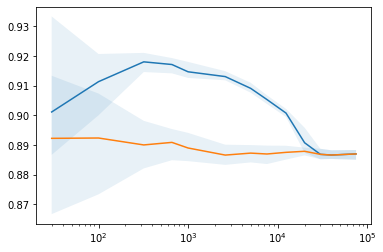

In [7]:
plot_with_statband_mean(mqlib.N, mqlib/mqlib.N/1.5)
plot_with_statband_mean(mqlib_t0costs.N, mqlib_t0costs/mqlib_t0costs.N/1.5)
plt.xscale('log')

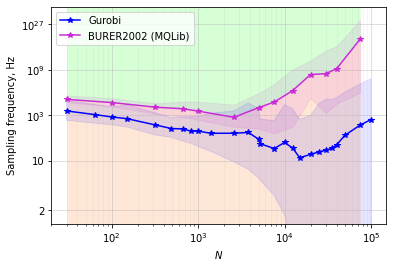

In [204]:
T = .0
colors = get_colors(3)
t_dps = xarray.apply_ufunc(partial(datapoint_at_time, time=T), gurobi, vectorize=True)
gen = xarray.apply_ufunc(lambda x: x['lb'], t_dps, vectorize=True)
gtm = xarray.apply_ufunc(lambda x: x['time'], t_dps, vectorize=True)
mqen = mqlib_t0costs
#mqen = mqlib
gcst = gen/gen.N/1.5
mqcst = mqen/mqen.N/1.5

start = 0
p = 11
m = approx_ratio(p)
gfreq = -np.log(gtm)+(gcst.N/1.9*((gcst - m)/qvar_coef)**2)
mqfreq = -np.log(mqlib_t0costs_t)+(mqlib.N/2.0*((mqcst - m)/qvar_coef)**2)
gfreqm = np.max([gfreq.data, np.log(1/gtm.data)], 0)
estim_times_mq = mqlib.N/256*3e-2
#mqfreqm = np.max([mqfreq.data, np.log(np.tile(1/estim_times_mq.data, (10, 1)).T)], 0)
mqfreqm = np.max([mqfreq.data, np.log(1/mqlib_t0costs_t)], 0)

plot_with_statband_mean(t_dps.N[start:], gfreqm[start:], .8, '*-', color=colors[0], label='Gurobi')

plot_with_statband_mean(mqlib.N[start:], mqfreqm[start:], .8, '*-', color=colors[1],
                        label='BURER2002 (MQLib)')

plt.xscale('log')
plt.yscale('log', base=2)
xlim = plt.xlim()
plt.xlim(*xlim)

plt.ylabel('Sampling frequency, Hz')
plt.xlabel('$N$')
dps_end = 10


# -- Shading
y0, y1 = plt.ylim()
cl_adv = "#99FF99"
cl_non = "#FFC59F"
cl_dis = "#FFB3B3"
cl_mod = "#FFFFB3"
alpha = 0.4
plt.fill_between(mqlib.N[start:], mqfreqm[start:].mean(-1), [y0]*len(mqlib.N),
                 color=cl_non, alpha=alpha, zorder=-1, linewidth=0)

plt.fill_between(mqlib.N[start:], mqfreqm[start:].mean(-1), [y1]*len(mqlib.N),
                 color=cl_adv, alpha=alpha, zorder=-1, linewidth=0)
plt.ylim(y0, y1)


#plt.plot(first_dps.N, tms.median('seed'), '*-')
plt.ylim(1/2, plt.ylim()[1])

ticks = [np.log(2), np.log(10), np.log(1000), np.log(1e9), np.log(1e27)]
labels = ['2', '10', '$10^3$', '$10^9$', '$10^{27}$']
plt.yticks(ticks=ticks, labels=labels)
# -- 

plt.legend()
plt.grid(alpha=.5)
plt.grid(which='minor', alpha=.15)

plt.savefig('./pdf/advantage_sampling_rate.pdf')

### Non-t0 sampling frequency

For both gurobi and MQLIB
```
For each N:
    for each seed:
        For each time and cost(t):
            find delta(p=11, cost)
            get frequency(delta)
```
    

In [205]:
def log_freq(delta, t, N):
    """
    Sampling frequency to bridge `delta` quality in `t` time
    """
    gamma_p = 0.128
    freq = -np.log(t)+(N/2.0*(delta/gamma_p)**2)
    return freq

def qaoa_log_freq(cost, t, N, p):
    delta = cost - approx_ratio(p)
    return log_freq(delta, t, N)

In [207]:
# Gurobi

gur_logfreq = xarray.DataArray(coords=gurobi.coords, dims=gurobi.dims)
gur_times = xarray.DataArray(coords=gur_logfreq.coords)
gur_deltas = xarray.DataArray(coords=gur_logfreq.coords)
for N in gurobi.N:
    for seed in gurobi.seed:
        item = gurobi.sel(seed=seed, N=N).data.item()
        m = to_mh(item)
        times, _, cost = m.get_history_data()
        ar = np.array(cost)/3*2/N.data
        times = np.array(times)
        gur_logfreq.loc[N, seed] = qaoa_log_freq(ar[0], times[0], N.data, p=11)
        logfreqs = qaoa_log_freq(ar, times, N.data, p=11)
        
        logfreqs = np.max([np.log(1/times), logfreqs], axis=0)
        gur_logfreq.loc[N, seed] = min(logfreqs)
        gur_times.loc[N, seed] = times[np.argmin(logfreqs)]
        

In [208]:
# MQLIB

mq_logfreq = xarray.DataArray(coords=dict(N=mqlib_results.N, seed=mqlib_results.seed), dims=('N', 'seed'))
mq_times = xarray.DataArray(coords=mq_logfreq.coords)
for N in mqlib_results.N:
    for seed in mqlib_results.seed:
        history = mqlib_results.sel(N=N, seed=seed, kind='history').data.item()
        times, cost = history['times'], history['costs']
        ar = np.array(cost)/3*2/N.data
        times = np.array(times)
        logfreqs = qaoa_log_freq(ar, times, N.data, p=11)
        
        logfreqs = np.max([np.log(1/times), logfreqs], axis=0)
        mq_logfreq.loc[N, seed] = min(logfreqs)
        mq_times.loc[N, seed] = times[np.argmin(logfreqs)]

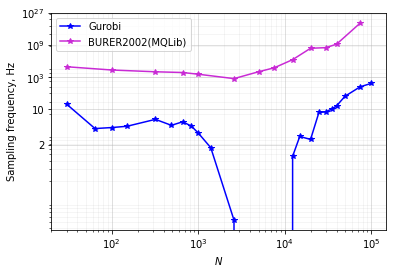

In [218]:
colors = get_colors(3)
gur_logfreq.mean('seed').plot(label='Gurobi', color=colors[0], marker='*')
mq_logfreq.mean('seed').plot(label='BURER2002(MQLib)', color=colors[1], marker='*')
plt.xscale('log')
plt.yscale('log')
ticks = [np.log(2), np.log(10), np.log(1000), np.log(1e9), np.log(1e27)]
labels = ['2', '10', '$10^3$', '$10^9$', '$10^{27}$']
plt.yticks(ticks=ticks, labels=labels)

plt.legend()
plt.grid(alpha=.5)
plt.grid(which='minor', alpha=.15)
plt.legend()

plt.ylabel('Sampling frequency, Hz')
plt.xlabel('$N$')
plt.savefig('./pdf/advantage_sampling_freq_topt.pdf')

Text(0, 0.5, 'Time, s')

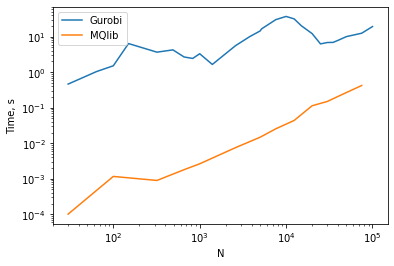

In [220]:
gur_times.mean('seed').plot(label='Gurobi')
mq_times.mean('seed').plot(label='MQlib')
plt.legend()

plt.xscale('log')
plt.yscale('log')
plt.ylabel('Time, s')

---